In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten
from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

2.14.1


C:\Users\shan\.conda\envs\alibi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# Load data. We only need good data and anything NOT good is an outlier.

image_directory = 'Dataset/carpet/train/'
SIZE = 64
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.

good_images = os.listdir(image_directory + 'good/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'good/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))

dataset = np.array(dataset)
dataset = dataset.astype('float32') / 255.

train = dataset
train.shape


(280, 64, 64, 3)

In [5]:


#Let us also load bad images to verify our trained model.
bad_images = os.listdir(image_directory + 'bad')
bad_dataset=[]
for i, image_name in enumerate(bad_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'bad/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        bad_dataset.append(np.array(image))
bad_dataset = np.array(bad_dataset)

bad_dataset = bad_dataset.astype('float32') / 255.
test = bad_dataset
test.shape

(19, 64, 64, 3)

In [6]:





#########################################################################
#Define the encoder - decoder network for input to the OutlierVAE detector class.
#Can be any encoder and decoder.

encoding_dim = 1024  #Dimension of the bottleneck encoder vector.
dense_dim = [8, 8, 512] #Dimension of the last conv. output. This is used to work our way back in the decoder.

#Define encoder
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

print(encoder_net.summary())
#print(encoder_net.input_shape)

#Define the decoder.
#Start with the bottleneck dimension (encoder vector) and connect to dense layer
#with dim = total nodes in the last conv. in the encoder.
decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

print(decoder_net.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 512)         1049088   
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
Total params: 34738880 (132.52 MB)
Trainable params: 34738880 (132.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: 

In [7]:



#######################################################################
#Define and train the outlier detector.

latent_dim = 1024  #(Same as encoding dim. )

# initialize outlier detector
od = OutlierVAE(threshold=.015,  # threshold for outlier score above which the element is flagged as an outlier.
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=4)

# print("Current threshold value is: ", od.threshold)

# train
#from alibi_detect.models.tensorflow.losses import elbo #evidence lower bound loss

adam = tf.keras.optimizers.Adam(learning_rate=1e-4)

od.fit(train,
       optimizer = adam,
       epochs=200,
       batch_size=4,
       verbose=True)

#Check the threshold value. Should be the same as defined before.
print("Current threshold value is: ", od.threshold)



70/70 [=] - 125s 2s/step - loss_ma: -20159.6398
Current threshold value is:  0.015


In [3]:
od

OutlierVAE

In [35]:
# from alibi_detect.utils import save_detector, load_detector  #If this does not work, try the next line
from alibi_detect.utils.saving import save_detector, load_detector #Use this if the above line does not work. 

In [36]:
save_detector(od, "saved_models/switch_100epoch_50_dataset.h5")

Directory saved_models\switch_100epoch_50_dataset.h5 does not exist and is now created.
Directory saved_models\switch_100epoch_50_dataset.h5\model does not exist and is now created.


C:\Users\shan\.conda\envs\alibi\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
od = load_detector("saved_models/carpet_od_20epochs.h5")

In [27]:
od

OutlierVAE

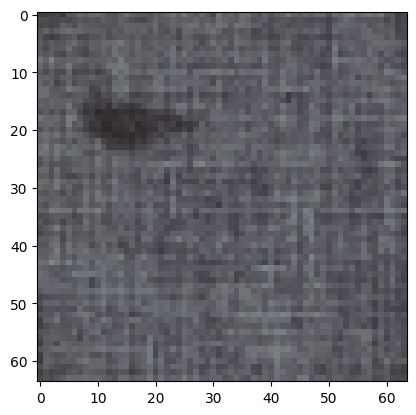

In [8]:

#Test our model on a bad image
img_num = 9
test_bad_image = bad_dataset[img_num].reshape(1, 64, 64, 3)
plt.imshow(test_bad_image[0])



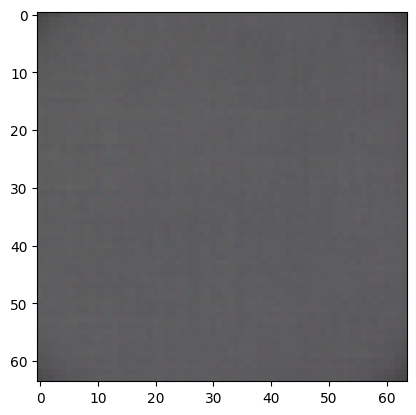

In [9]:
test_bad_image_recon = od.vae(test_bad_image)
test_bad_image_recon = test_bad_image_recon.numpy()
plt.imshow(test_bad_image_recon[0])


The instance score is: 0.0028511628
Is this image an outlier (0 for NO and 1 for YES)? 0


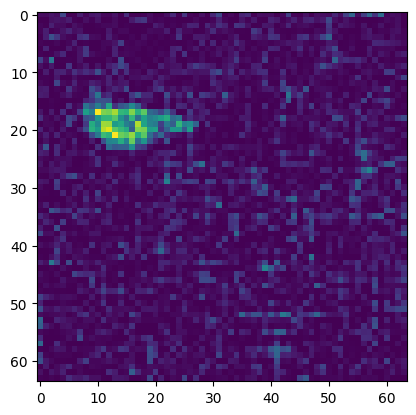

In [10]:

test_bad_image_predict = od.predict(test_bad_image) #Returns a dictionary of data and metadata

#Data dictionary contains the instance_score, feature_score, and whether it is an outlier or not. 
#Let u look at the values under the 'data' key in our output dictionary
bad_image_instance_score = test_bad_image_predict['data']['instance_score'][0]
print("The instance score is:", bad_image_instance_score)

bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
plt.imshow(bad_image_feature_score[:,:,0])
print("Is this image an outlier (0 for NO and 1 for YES)?", test_bad_image_predict['data']['is_outlier'][0])

Current threshld value is:  0.002
['instance_score', 'feature_score', 'is_outlier']


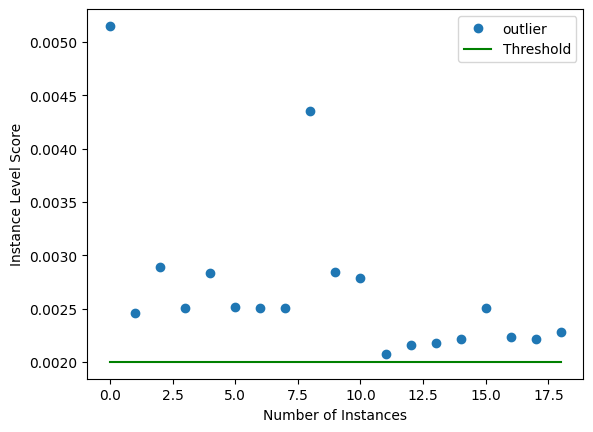

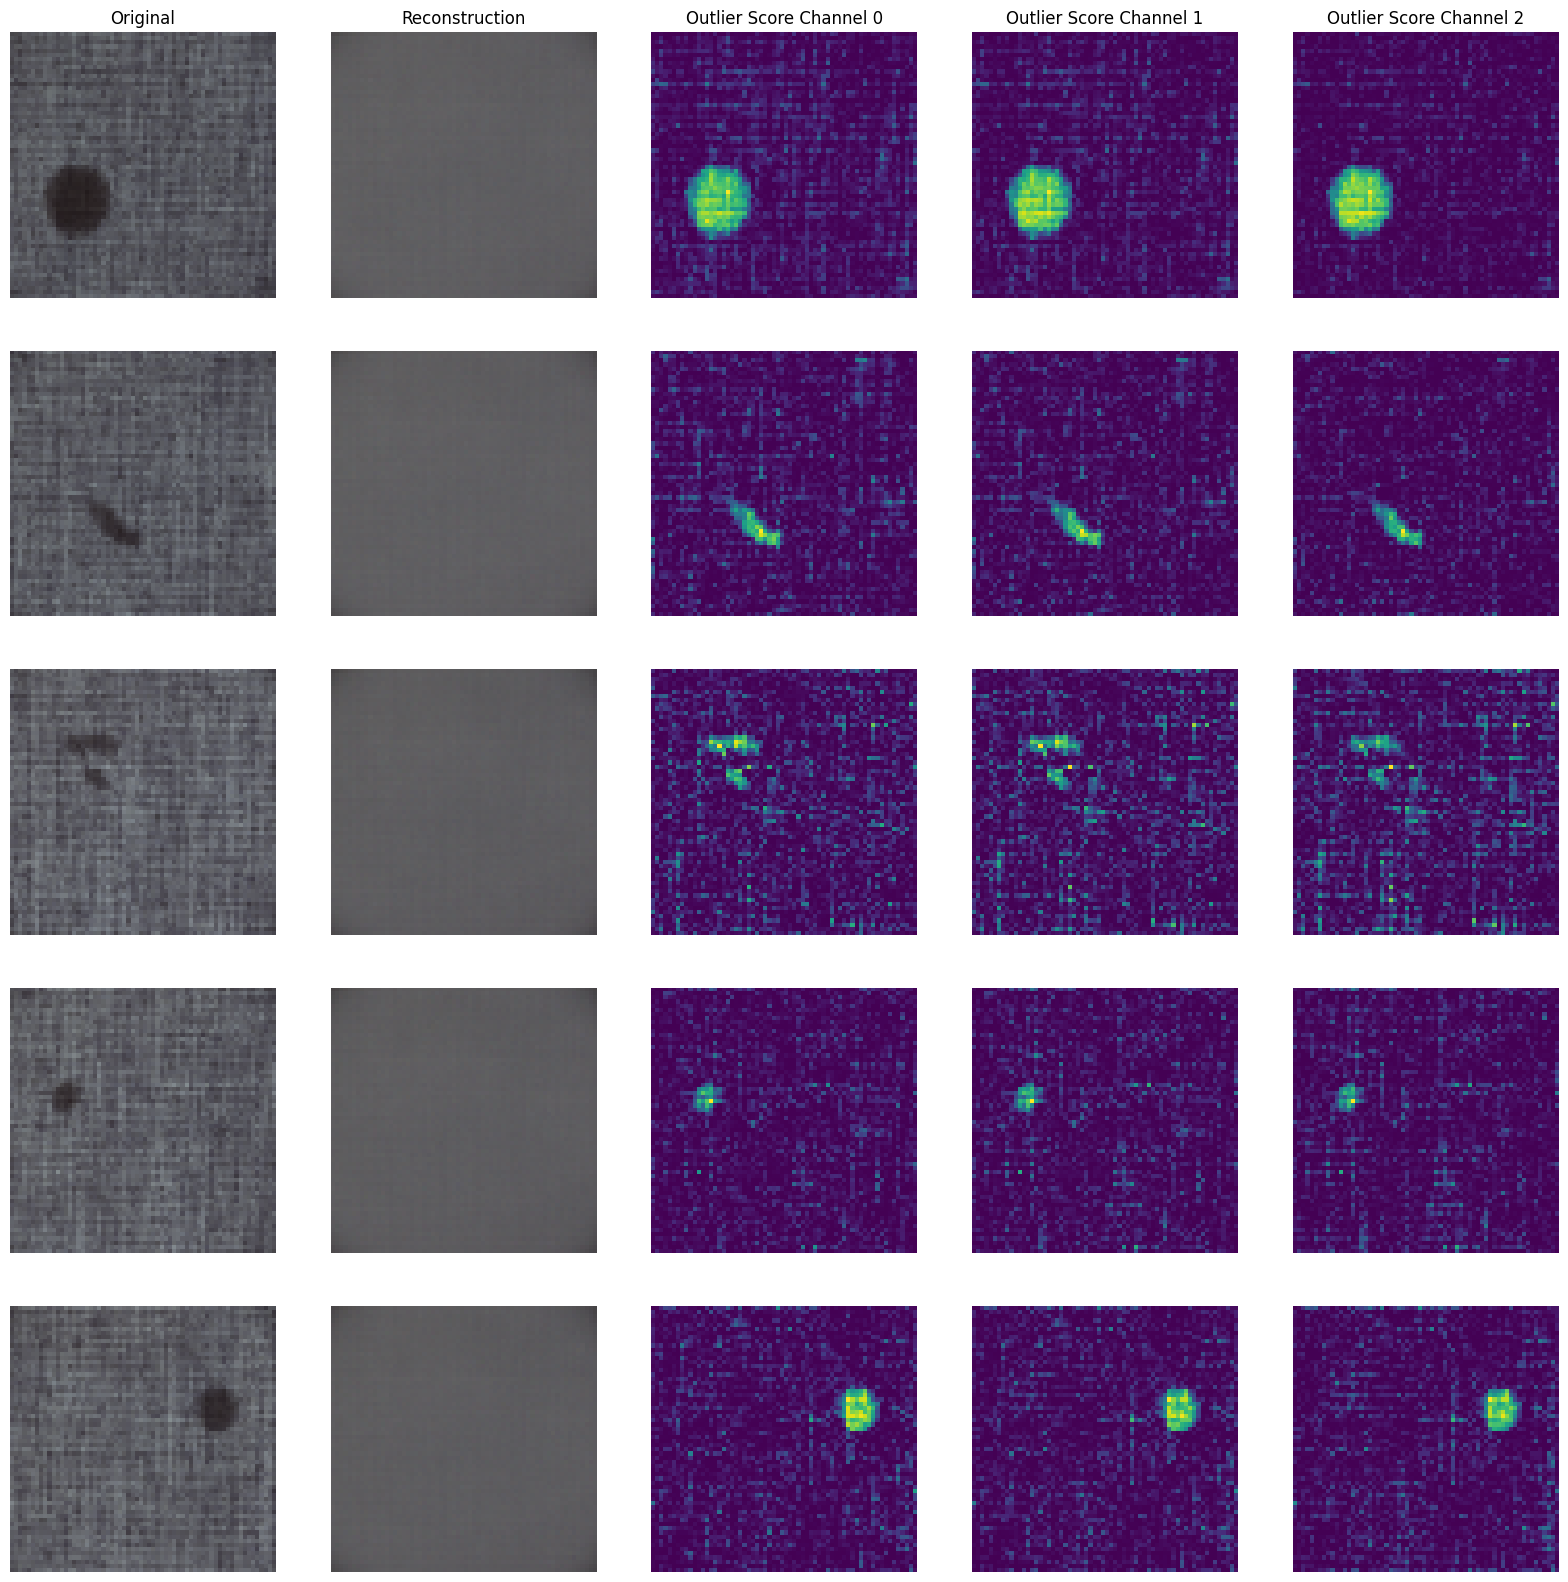

In [11]:
#You can also manually define the threshold based on your specific use case. 
od.threshold =  0.002
print("Current threshld value is: ", od.threshold)

#Let us check it for multiple images
X = bad_dataset

od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

print(list(od_preds['data'].keys()))

#Scatter plot of instance scores. using the built-in function for the scatterplot. 
target = np.ones(X.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold) #pred, target, labels, threshold

#Plot features for select images, using the built in function (plot_feature_outlier_image)
X_recon = od.vae(X).numpy()
# plot_feature_outlier_image(od_preds,
#                            X,
#                            X_recon=X_recon,
#                            instance_ids=[0, 5, 10, 15, 17],  # pass a list with indices of instances to display
#                            max_instances=5,  # max nb of instances to display
#                            outliers_only=False)  # only show outlier predictions
plot_feature_outlier_image(od_preds,
                           X,
                           X_recon=X_recon,
                         
                           max_instances=5,  # max nb of instances to display
                           outliers_only=False)  # only show outlier predictions

#######################################


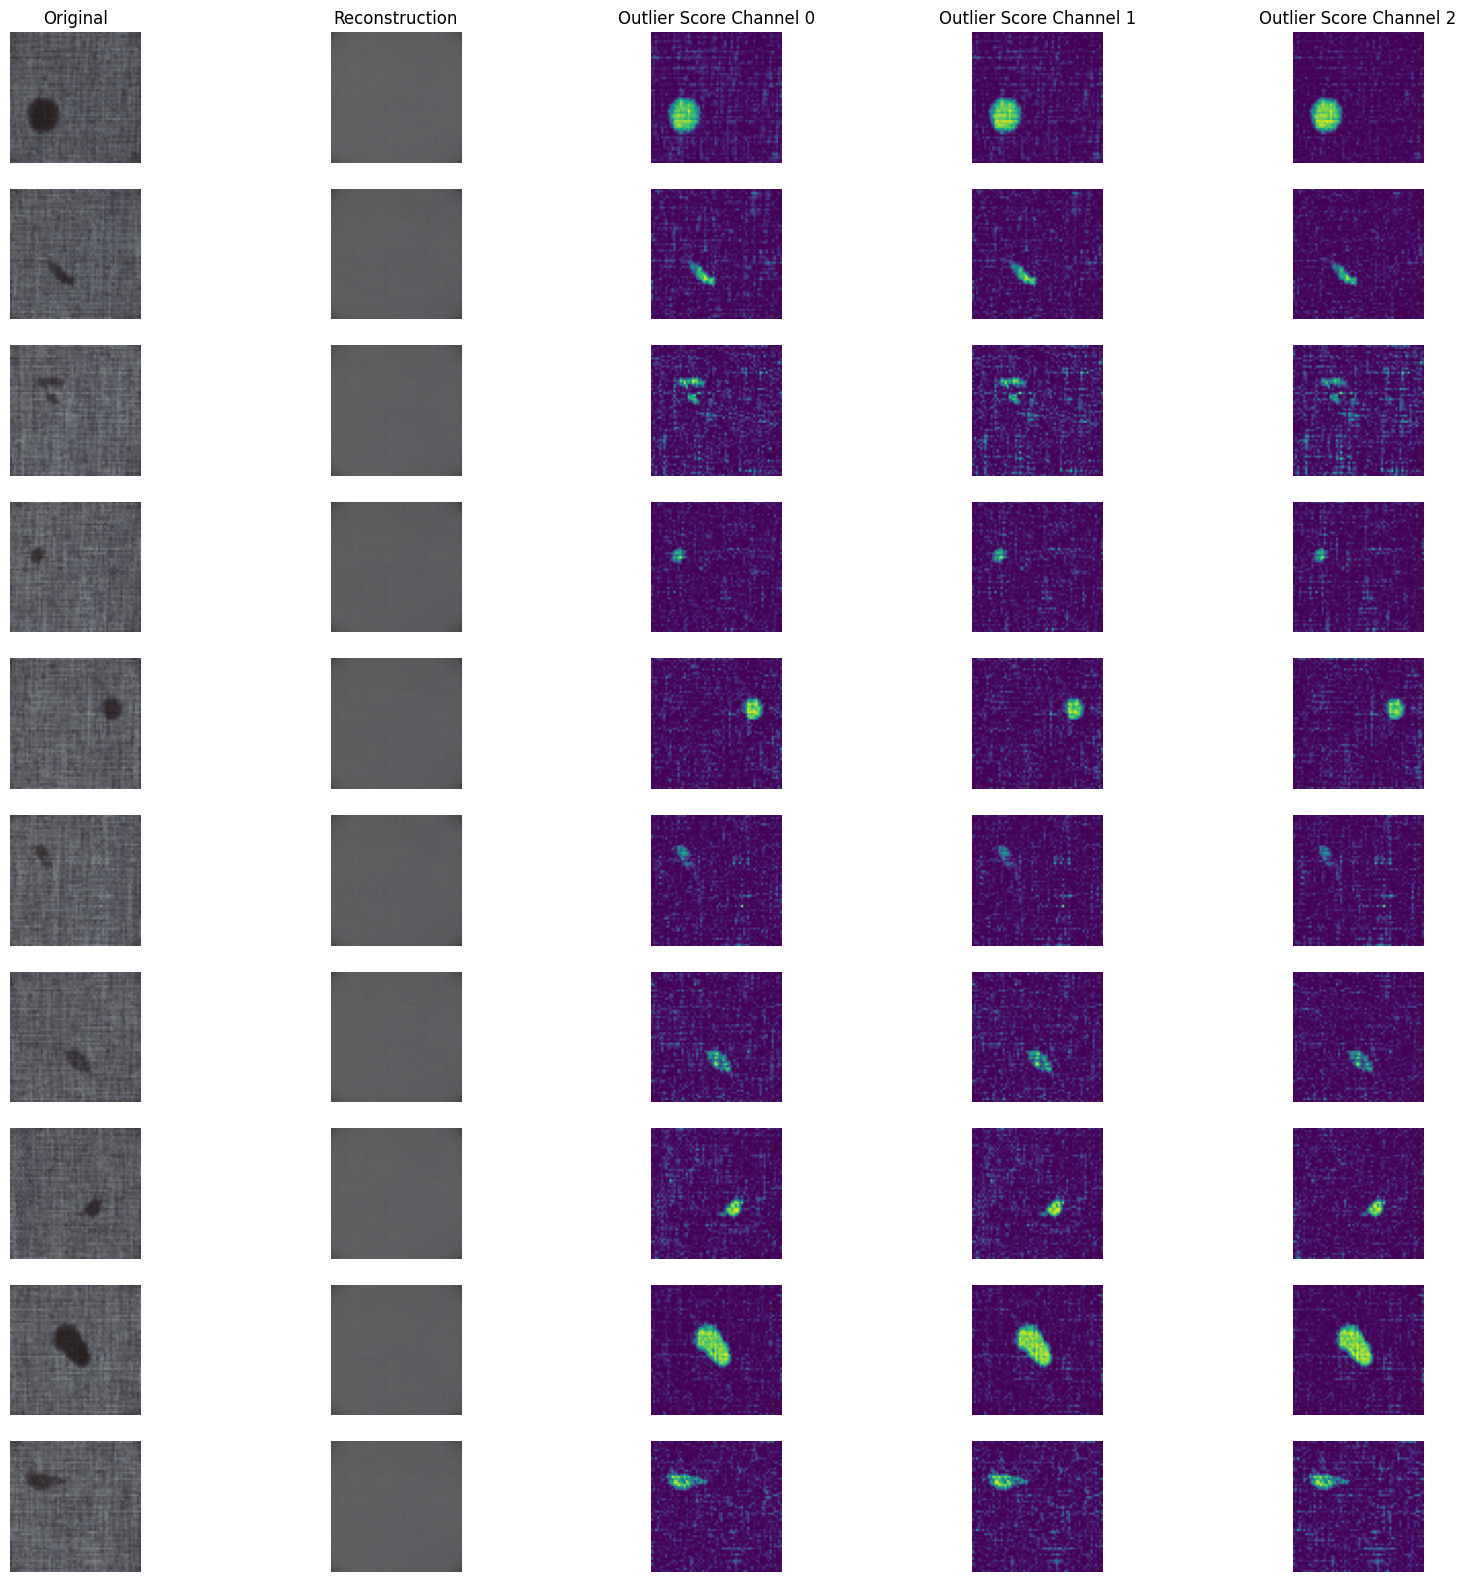

In [12]:
#Plot features for select images, using the built in function (plot_feature_outlier_image)
X_recon = od.vae(X).numpy()
# plot_feature_outlier_image(od_preds,
#                            X,
#                            X_recon=X_recon,
#                            instance_ids=[0, 5, 10, 15, 17],  # pass a list with indices of instances to display
#                            max_instances=5,  # max nb of instances to display
#                            outliers_only=False)  # only show outlier predictions


######################################
plot_feature_outlier_image(od_preds,
                           X,
                           X_recon=X_recon,
    # pass a list with indices of instances to display
                           max_instances=10,  # max nb of instances to display
                           outliers_only=True)  # only show outlier predictions